# Model Design

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scripts.data_processor import load_processed_data

classes = {1: 'new', 0: 'used'} # tags for human readabilty
save_graph = True # Option for saving graphs' images

In [ ]:
# Logging file
try:
    history = pd.read_csv('./data/train_logs.csv',index_col='training')
    print("Logging file loaded from './data/train_logs.csv'.")
    print(f"Register contains data of {len(history)} trainings.")
except FileNotFoundError:
    print("Logging file was not found. A new logging file was created.")
    history = pd.DataFrame(columns=['features','model','items','cm','metrics','roc_auc'])
    history.index.name = 'training' # Set the name for the DataFrame's index
except Exception as e:
    # Catch other potential errors during CSV loading (e.g., parsing errors)
    print(f"An unexpected error occurred while loading the logging file: {e}")
    print("Creating a new logging file instead.")
    history = pd.DataFrame(columns=['features', 'model', 'items', 'cm', 'metrics', 'roc_auc'])
    history.index.name = 'training'
history

Logging file loaded from './data/train_logs.csv'.
Register contains data of 1 trainings.


,features,model,items,cm,metrics,roc_auc
training,,,,,,
0,"{'train': {'feat': ['accepts_mercadopago', 'au...",LogisticRegression,"{'train': 89109, 'test': 9905}",[[0.95905777 0.04094223]\n [0.52875329 0.47124...,"{'new': {'precision': 0.6804615996816554, 'rec...",0.715152


***NOTE:*** *Each section of this notebook should be run independently, as they correspond to distinct iterations of the productive cycle, alternating between EDA & Feature Selection (`EDA.ipynb`) and Train & Evaluate (`model_design.ipynb`).*

---



# 1º iteration - Quick training test

In [126]:
index = len(history) # used for logging

In [25]:
X_train, y_train, X_test, y_test = load_processed_data()

Importing data from 'new_or_used.py'…
Starting preprocessing…
Succesfully finished.



In [127]:
y_train_lbl = y_train.map(classes)
y_test_lbl = y_test.map(classes)

### Dataset info

In [133]:
size = {'train':len(X_train),'test':len(X_test)}
print("Split sizes: {} train, {} test".format(size['train'], size['test']))

Split sizes: 89109 train, 9905 test


In [134]:
features = {'train': {'feat': None, 'target': None},
            'test': {'feat': None, 'target': None}}

In [135]:
history.columns

Index(['features', 'model', 'items', 'cm', 'metrics', 'roc_auc'], dtype='object')

In [136]:
history

,features,model,items,cm,metrics,roc_auc
0,NaN,NaN,NaN,NaN,NaN,NaN


#### Train split

In [137]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89109 entries, 0 to 89108
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accepts_mercadopago           89109 non-null  uint8  
 1   automatic_relist              89109 non-null  uint8  
 2   price_scaled                  89109 non-null  float64
 3   initial_quantity_scaled       89109 non-null  float64
 4   is_USD                        89109 non-null  uint8  
 5   listing_type_id_free          89109 non-null  float64
 6   listing_type_id_gold          89109 non-null  float64
 7   listing_type_id_gold_premium  89109 non-null  float64
 8   listing_type_id_gold_pro      89109 non-null  float64
 9   listing_type_id_gold_special  89109 non-null  float64
 10  listing_type_id_silver        89109 non-null  float64
 11  buying_mode_buy_it_now        89109 non-null  float64
 12  buying_mode_classified        89109 non-null  float64
 13  s

In [138]:
y_train_lbl.value_counts()

new     47859
used    41250
Name: count, dtype: int64

In [139]:
y_train_lbl.value_counts().to_dict()

{'new': 47859, 'used': 41250}

#### Test split

In [140]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9905 entries, 0 to 9904
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accepts_mercadopago           9905 non-null   uint8  
 1   automatic_relist              9905 non-null   uint8  
 2   price_scaled                  9905 non-null   float64
 3   initial_quantity_scaled       9905 non-null   float64
 4   is_USD                        9905 non-null   uint8  
 5   listing_type_id_free          9905 non-null   float64
 6   listing_type_id_gold          9905 non-null   float64
 7   listing_type_id_gold_premium  9905 non-null   float64
 8   listing_type_id_gold_pro      9905 non-null   float64
 9   listing_type_id_gold_special  9905 non-null   float64
 10  listing_type_id_silver        9905 non-null   float64
 11  buying_mode_buy_it_now        9905 non-null   float64
 12  buying_mode_classified        9905 non-null   float64
 13  sta

In [141]:
y_test_lbl.value_counts()

new     5349
used    4556
Name: count, dtype: int64

#### Logging

In [142]:
# Keep tracking of every feature
history.at[index, 'items'] = size
features['train']['feat'] = X_train.columns.to_list()
features['test']['feat'] = X_test.columns.to_list()
features['train']['target'] = y_train_lbl.value_counts().to_dict()
features['test']['target'] = y_test_lbl.value_counts().to_dict()
history.at[index, 'features'] = features

## Model training

In [ ]:
# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42)
history.at[index, 'model'] = model.__class__.__name__ # for logging

In [146]:
# Train the model using the scaled training data
print("Training the Logistic Regression model...")
model.fit(X_train, y_train)
print("Model training complete.")

Training the Logistic Regression model...
Model training complete.


## Model evaluation

In [35]:
# Predict on the scaled test data
y_pred = model.predict(X_test)
y_pred_lbl = pd.Series(y_pred).map(classes)

# Getprediction probabilities (useful for ROC curves, etc.
y_pred_proba = model.predict_proba(X_test) 

In [ ]:
# PERFORMANCE EVALUATION
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report (provides Precision, Recall, F1-Score for each class)
class_report = classification_report(y_test_lbl, y_pred_lbl,digits=3)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.7347

Classification Report:
              precision    recall  f1-score   support

         new      0.680     0.959     0.796      5349
        used      0.907     0.471     0.620      4556

    accuracy                          0.735      9905
   macro avg      0.794     0.715     0.708      9905
weighted avg      0.785     0.735     0.715      9905



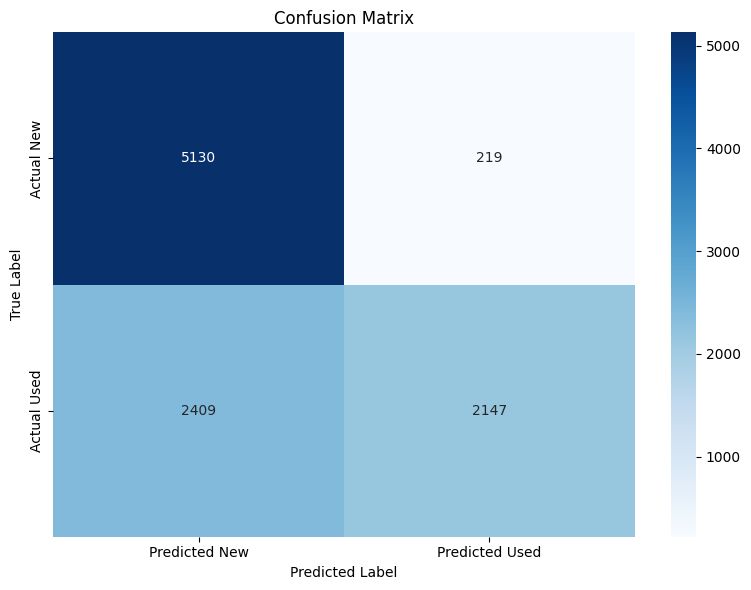

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_lbl, y_pred_lbl)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted New', 'Predicted Used'],
            yticklabels=['Actual New', 'Actual Used'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
if save_graph: plt.savefig('confusion_matrix.png')

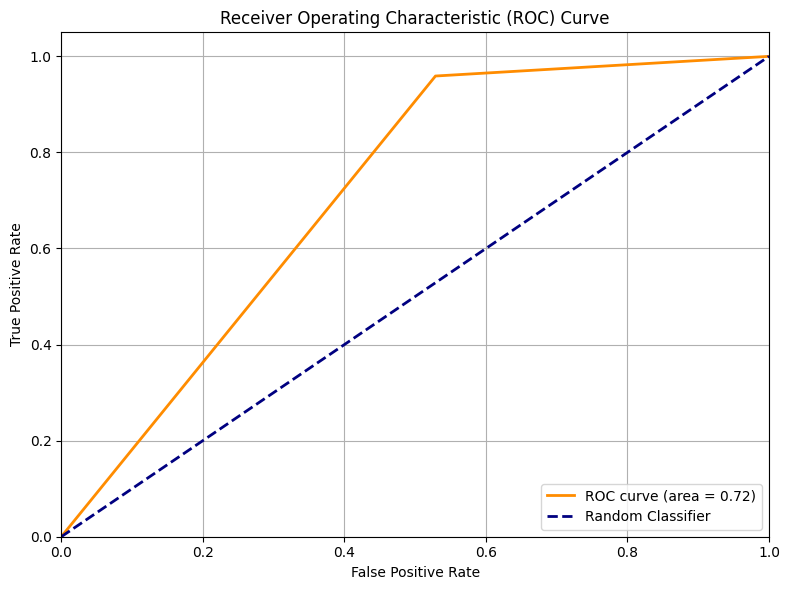

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the probabilities of the positive class (second column)
#y_pred_proba_positive = y_pred_proba[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
if save_graph: plt.savefig('roc_auc_curve.png')

#### Logging

In [ ]:
# Keep tracking of every metric
history.at[index, 'cm'] = confusion_matrix(y_test_lbl, y_pred_lbl,normalize='true').tolist()
history.at[index, 'metrics'] = classification_report(y_test_lbl, y_pred_lbl,output_dict=True)
history.at[index, 'roc_auc'] = auc(fpr, tpr)
history.to_csv('./data/train_logs.csv') # Save logging file locally

In [193]:
history.iloc[index]

features    {'train': {'feat': ['accepts_mercadopago', 'au...
model                                      LogisticRegression
items                          {'train': 89109, 'test': 9905}
cm          [[0.9590577678070668, 0.04094223219293326], [0...
metrics     {'new': {'precision': 0.6804615996816554, 'rec...
roc_auc                                              0.715152
Name: 0, dtype: object

## Analysis

**Key Takeaways:**

1.  **Class Imbalance in Prediction Quality:** The model is **heavily biased towards predicting "new."** It's excellent at identifying "new" items (high recall of 0.96 for 'new'), meaning it correctly catches 96% of all actual "new" items. However, it **struggles significantly with identifying "used" items** (low recall of 0.47 for 'used'), correctly identifying less than half of them. When the model does predict "used," it's usually correct (high precision of 0.91 for 'used'), but it misses a substantial number of actual "used" items. This manifests as a high count of **False Negatives for 'used'** (actual 'used' items misclassified as 'new') and, equivalently, a high count of **False Positives for 'new'** (actual 'used' items misclassified as 'new').

2.  **High False Positives for "new" / High False Negatives for "used":** The **2409 False Positives for "new"** in the confusion matrix explicitly mean that 2409 items that were **actually "used" were incorrectly classified as "new."** This large number directly explains the low recall for "used" ($2147 \text{ TP} / (2147 \text{ TP} + 2409 \text{ FN}) = 0.47$).

3.  **Accuracy is Misleading:** With a significant imbalance in performance across classes and given the class distribution (5349 'new' vs. 4556 'used'), **accuracy alone is not a reliable metric.** The model's strong performance on the slightly larger class ('new') inflates the overall accuracy, masking its poor ability to identify 'used' items.

**Conclusions:**

* Some features are **poor predictors** of the target, showing **correlations close to 0**. This likely contributes to the high number of false positives observed.
* The continuous variables `price` and `quantity` exhibit **highly skewed distributions** with a significant presence of positive outliers. For 'cantidad' in particular, it appears more beneficial to consider if the quantity is simply **greater than 1**, as this seems to influence the probability of an item being 'new'. This suggests a valuable opportunity for feature engineering.
* Regarding the **dummy variables for `listing_type_id`**, only certain categories appear to be relevant. Specifically, the distinction between **paid and free users** seems to be a key differentiator. Notably, 'gold_pro' and 'gold_premium' tiers show little correlation, while lower-tier categories exhibit stronger predictive power.
* The **`status` variable** should not be considered for the model, as the **vast majority of items are 'active'**, providing very little discriminating information.